In [2]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!pip install -qqq openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.5/328.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.0 MB/s eta 0:00:00


In [4]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('openai-key')

## Zero-shot categorization
Extract 20 news titles from each category of sentiments.

In [36]:
import random

# File path
file_path = 'Sentences_AllAgree.txt'

# Function to load and categorize news titles
def load_and_categorize_news(file_path):
    positive = []
    negative = []
    neutral = []

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            if line.strip().endswith('@positive'):
                positive.append(line.strip())
            elif line.strip().endswith('@negative'):
                negative.append(line.strip())
            elif line.strip().endswith('@neutral'):
                neutral.append(line.strip())

    return positive, negative, neutral

# Function to randomly extract 20 titles from each category
def get_random_titles(positive, negative, neutral, num_samples):
    selected_positive = random.sample(positive, num_samples)
    selected_negative = random.sample(negative, num_samples)
    selected_neutral = random.sample(neutral, num_samples)

    return selected_positive, selected_negative, selected_neutral

# Load and categorize news titles
positive, negative, neutral = load_and_categorize_news(file_path)

# Get random titles
selected_positive, selected_negative, selected_neutral = get_random_titles(positive, negative, neutral, 20)

# Combine titles in the required order
ordered_titles = selected_positive + selected_negative + selected_neutral

# Function to strip labels from titles and keep labels
def strip_labels(titles):
    stripped_titles = []
    labels = []
    for title in titles:
        label = title.split('@')[-1]
        stripped_title = title.rsplit('@', 1)[0]
        stripped_titles.append(stripped_title)
        labels.append(label)
    return stripped_titles, labels

# Strip labels from titles and keep the labels
stripped_titles, original_labels = strip_labels(ordered_titles)

Now, prepare the chat-completion API for zero-shot categorization

In [37]:
from openai import OpenAI
client = OpenAI()

# Define the zero-shot prompt
def create_prompt(title):
    return f"Please categorize the following news title as Positive, Negative, or Neutral on the stock price from the viewpoint of a retail investor.:\n\nTitle: {title}"

# Function to categorize a title using OpenAI's API
def categorize_title(title):
    prompt = create_prompt(title)
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant that categorizes news titles correctly."},
            {"role": "user", "content": prompt}
        ]
    )

    # Ensure only the label is returned
    response_text = response.choices[0].message.content.strip().lower()
    if "positive" in response_text:
        return "positive"
    elif "negative" in response_text:
        return "negative"
    elif "neutral" in response_text:
        return "neutral"
    else:
        return "unknown" # handle unexpected cases

# Categorize each title and store the results
predicted_labels = [categorize_title(title) for title in stripped_titles]

# Convert original labels to lowercase for comparison
original_labels = [label.lower() for label in original_labels]

# Compare the original and predicted labels and calculate accuracy
correct_predictions = sum(1 for orig, pred in zip(original_labels, predicted_labels) if orig == pred)
total_predictions = len(original_labels)
accuracy = correct_predictions / total_predictions

# Print the results and accuracy
print(f"Correct Predictions: {correct_predictions}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print detailed results
for title, orig_label, pred_label in zip(stripped_titles, original_labels, predicted_labels):
    print(f"Title: {title}\nOriginal Label: {orig_label}\nPredicted Label: {pred_label}\n")


Correct Predictions: 55
Accuracy: 91.67%
Title: Operating profit increased by 145.1 % to EUR 8.3 mn from EUR 3.4 mn .
Original Label: positive
Predicted Label: positive

Title: Favourable currency rates also contributed to higher net sales , '' CEO Kari Kauniskangas said .
Original Label: positive
Predicted Label: positive

Title: Total operating revenue grew by 27.6 % year-on-year to EUR61m .
Original Label: positive
Predicted Label: positive

Title: Both operating profit and sales for the three-month period increased , respectively from EUR0 .3 m and EUR13 .1 m , as compared to the corresponding period in 2005 .
Original Label: positive
Predicted Label: positive

Title: Last year the company raised its turnover to approximately 7 million litas EUR 2 mln , from 6.1 million litas in 2004 .
Original Label: positive
Predicted Label: positive

Title: According to Nordic financial group Nordea 's analyst Sami Sarkamies , this makes Nokia 's portfolio competitive again .
Original Label: pos

**RESULTS & OBSERVATIONS**

As seen above, the zero-shot prompting for 60 news titles, resulted in the accuracy of 86.67%, predicting sentiment of 52 news titles accurately. Earlier, I had also tried just 30 titles, which achieved accuracy of 76.67%.

## Training with 12 sample Sentiments

In [14]:
# Define example news titles with corresponding sentiment labels
examples = [
    {"title": "Exports grew 16.5 percent to 19.1 million liters.", "label": "positive"},
    {"title": "Sales in Latin America increased by 42% to EUR 432mn.", "label": "positive"},
    {"title": "Profit for the period was EUR 5.9 mn, up from EUR 1.3 mn.", "label": "positive"},
    {"title": "Diluted earnings per share (EPS) rose to EUR 1.05 from EUR 0.64.", "label": "positive"},
    {"title": "Consolidated operating profit from continuing operations decreased by 62.3%.", "label": "negative"},
    {"title": "Operating profit fell to EUR 20.3 mn from EUR 74.2 mn.", "label": "negative"},
    {"title": "The net sales decreased to EUR 49.8 million from EUR 59.9 million.", "label": "negative"},
    {"title": "The company reported today an operating loss of EUR0.1 m on net sales of EUR4.5 m.", "label": "negative"},
    {"title": "Helsinki 19 May 2010 - Finnish company Lemminkainen Oyj said today that it will construct an office building.", "label": "neutral"},
    {"title": "The new organization consists of two business units: Charging & Messaging and Finance & Administration.", "label": "neutral"},
    {"title": "Group net sales in the third quarter of 2007 totaled EUR 142.3 mn.", "label": "neutral"},
    {"title": "The value of the order is USD 2.3 mn.", "label": "neutral"}
]

# Define the zero-shot prompt with examples
def create_prompt_with_examples(title):
    examples_text = "\n".join([f"Title: {ex['title']}\nLabel: {ex['label']}" for ex in examples])
    return f"Here are some examples of news titles with their corresponding sentiment labels:\n\n{examples_text}\n\nBased on these examples, please categorize the following news title as Positive, Negative, or Neutral:\n\nTitle: {title}"

# Function to categorize a title using OpenAI's API with examples
def categorize_title_with_examples(title):
    prompt = create_prompt_with_examples(title)
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant that labels sentiments of news titles as in the examples provided."},
            {"role": "user", "content": prompt}
        ]
    )
    # Ensure only the label is returned
    response_text = response.choices[0].message.content.strip().lower()
    if "positive" in response_text:
        return "positive"
    elif "negative" in response_text:
        return "negative"
    elif "neutral" in response_text:
        return "neutral"
    else:
        return "unknown"  # Handle unexpected cases

# Categorize each title and store the results using the new function with examples
predicted_labels_with_examples = [categorize_title_with_examples(title) for title in stripped_titles]

# Compare the original and predicted labels and calculate accuracy
correct_predictions_with_examples = sum(1 for orig, pred in zip(original_labels, predicted_labels_with_examples) if orig == pred)
total_predictions_with_examples = len(original_labels)
accuracy_with_examples = correct_predictions_with_examples / total_predictions_with_examples

# Print the results and accuracy
print(f"Correct Predictions with Examples: {correct_predictions_with_examples}")
print(f"Accuracy with Examples: {accuracy_with_examples * 100:.2f}%")

# Print detailed results with examples
for title, orig_label, pred_label in zip(stripped_titles, original_labels, predicted_labels_with_examples):
    print(f"Title: {title}\nOriginal Label: {orig_label}\nPredicted Label with Examples: {pred_label}\n")


Correct Predictions with Examples: 58
Accuracy with Examples: 96.67%
Title: Finnish consulting and engineering group Poyry Plc ( OMX Helsinki : POY ) said on Wednesday ( 1 October ) that it has been awarded a contract by Tanqia Dibba FZC as owner-engineer for the wastewater system of Dibba , Emirate of Fujairah , UAE .
Original Label: positive
Predicted Label with Examples: neutral

Title: Both operating profit and net sales for the six-month period increased , respectively from EUR18 .1 m and EUR127 .6 m , as compared to the corresponding period in 2006 .
Original Label: positive
Predicted Label with Examples: positive

Title: Finnish telecoms software developer Tecnomen Oyj said on December 5 , 2006 it won a $ 3.3 mln ( 2.5 mln euro ) order to supply an expansion of the charging and messaging systems for the mobile and fixed networks of Brasil Telecom .
Original Label: positive
Predicted Label with Examples: positive

Title: Both the net sales and operating profit were record high in

**RESULTS & OBSERVATIONS**

After providing just 4 examples of the correct sentiments for each category, the accuracy improved to 96.67% for the same data set of news titles as used earlier. It is evident that with 12-shot prompting, there is an uptick in accuracy. This is because the model has more information on how to predict similar news titles.

## Prepare training data for FineTuning
From each category of sentiments, 150 news titles are randomly selected and put together in a jsonl format which is later used to fine-tune the GPT-3.5-turbo model.

In [38]:
import json

#Extract training data: 150 titles from each category
train_positive, train_negative, train_neutral = get_random_titles(positive, negative, neutral, 150)

# Modify the data structure to a list of dictionaries
# train_data = [{'title': title, 'label': label} for category in [train_positive, train_negative, train_neutral] for title, label in category]

# Modify the data structure to a list of dictionaries
train_data = []
for category, label in zip([train_positive, train_negative, train_neutral], ['positive', 'negative', 'neutral']):
    for title in category:
        train_data.append({'title': title.split('@')[0].strip(), 'label': label})


# Save training data to JSON file
with open('train_data.json', 'w', encoding='utf-8') as train_file:
    json.dump(train_data, train_file, ensure_ascii=False, indent=4)

#define the system message
system_message = "You are a helpful assistant to categorize news title as 'positive', 'negative', or 'neutral' based on its impact on stock prices from the viewpoint of a retail investor."

# Function to convert the training data to jsonl format
def convert_to_jsonl_format(data):
    jsonl_data = []
    for item in data:
        title = item['title']
        label = item['label']
        jsonl_entry = {
            "messages": [
                {"role": "system", "content": system_message},
                {"role": "user", "content": title},
                {"role": "assistant", "content": label}
            ]
        }
        jsonl_data.append(jsonl_entry)
    return jsonl_data

# Convert training data to jsonl format
jsonl_train_data = convert_to_jsonl_format(train_data)

# Save the jsonl formatted data to a file
with open('train_data.jsonl', 'w', encoding='utf-8') as jsonl_file:
    for entry in jsonl_train_data:
        jsonl_file.write(json.dumps(entry, ensure_ascii=False) + '\n')

print("Training data has been saved in 'train_data.jsonl' format.")

Training data has been saved in 'train_data.jsonl' format.


create a unique file for fine-tuning model

In [22]:
with open('train_data.jsonl', 'rb') as file:
    result = client.files.create(
        file=file,
        purpose='fine-tune'
    )

# Get the file ID
file_id = result.id

print(f"File ID: {file_id}")

File ID: file-k5Ij54hXdjOHABhTzUhk6WxI


In [25]:

client.fine_tuning.jobs.create(
  training_file=file_id,
  model="gpt-3.5-turbo"
)

FineTuningJob(id='ftjob-HifZTGGXmbGuZfs5GBqo0r2I', created_at=1720743864, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-1S6yJfTUME6AFF6HTQsDM3Mi', result_files=[], seed=1561064069, status='validating_files', trained_tokens=None, training_file='file-k5Ij54hXdjOHABhTzUhk6WxI', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [26]:
client.fine_tuning.jobs.list()

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-HifZTGGXmbGuZfs5GBqo0r2I', created_at=1720743864, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-1S6yJfTUME6AFF6HTQsDM3Mi', result_files=[], seed=1561064069, status='validating_files', trained_tokens=None, training_file='file-k5Ij54hXdjOHABhTzUhk6WxI', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None), FineTuningJob(id='ftjob-LPSrv6RyTZ3GY0xKiRNzqbt2', created_at=1720729054, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:personal::9jv7YYhU', finished_at=1720731359, hyperparameters=Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-1S6yJfTUME6AFF6HTQsD

In [28]:
client.fine_tuning.jobs.retrieve("ftjob-HifZTGGXmbGuZfs5GBqo0r2I")

FineTuningJob(id='ftjob-HifZTGGXmbGuZfs5GBqo0r2I', created_at=1720743864, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-1S6yJfTUME6AFF6HTQsDM3Mi', result_files=[], seed=1561064069, status='running', trained_tokens=None, training_file='file-k5Ij54hXdjOHABhTzUhk6WxI', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

## Prepare Test data set


In [39]:
# Extract test data: 500 titles from the remaining data
remaining_positive = [item for item in positive if item not in train_positive]
remaining_negative = [item for item in negative if item not in train_negative]
remaining_neutral = [item for item in neutral if item not in train_neutral]

# Ensuring there are enough remaining titles to sample from
remaining_positive = remaining_positive[:500]
remaining_negative = remaining_negative[:500]
remaining_neutral = remaining_neutral[:500]

test_positive, test_negative, test_neutral = get_random_titles(remaining_positive, remaining_negative, remaining_neutral, 153)
test_data = test_positive + test_negative + test_neutral
test_data = [{'title': title.split('@')[0].strip(), 'label': title.split('@')[-1]} for title in test_data]

# Save test data to JSON file
with open('test_data.json', 'w', encoding='utf-8') as test_file:
    json.dump(test_data, test_file, ensure_ascii=False, indent=4)

## Predictions with Fine-Tuned Model


In [31]:
# Load test data
with open('test_data.json', 'r', encoding='utf-8') as test_file:
    test_data = json.load(test_file)

# Define the system message
system_message = "You are a helpful assistant to categorize news title as 'positive', 'negative', or 'neutral' based on its impact on stock prices from the viewpoint of a retail investor."

# Function to create prompt for the fine-tuned model
def create_prompt_with_examples(title):
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": title}
    ]

# Function to make predictions using the fine-tuned GPT model
def predict_sentiment(title):
    prompt = create_prompt_with_examples(title)
    response = client.chat.completions.create(
        model="ft:gpt-3.5-turbo-0125:personal::9jzE106Q",  # Replace with your fine-tuned model name
        messages=prompt
    )
    response_text = response.choices[0].message.content.strip().lower()
    # Ensure only the label is returned
    if "positive" in response_text:
        return "positive"
    elif "negative" in response_text:
        return "negative"
    elif "neutral" in response_text:
        return "neutral"
    else:
        return "unknown"  # Handle unexpected cases

# Predict sentiments for the test data
predicted_labels = [predict_sentiment(item['title']) for item in test_data]

# Extract original labels for comparison
original_labels = [item['label'].lower() for item in test_data]

# Compare the original and predicted labels and calculate accuracy
correct_predictions = sum(1 for orig, pred in zip(original_labels, predicted_labels) if orig == pred)
total_predictions = len(original_labels)
accuracy = correct_predictions / total_predictions

# Print the results and accuracy
print(f"Correct Predictions: {correct_predictions}")
print(f"Total Predictions: {total_predictions}")
print(f"Accuracy: {accuracy * 100:.2f}%")

Correct Predictions: 452
Total Predictions: 459
Accuracy: 98.47%


With the fine-tuned LLM, the model is able to predict the news sentiments more accurately than before. With 98.47% accuracy when tested against 459 news titles, 452 were accurately classified. This is an expected results as the model has learned about the new information that were not present in training the foundational model.

## **Confusion Matrix**


              precision    recall  f1-score   support

    positive       1.00      0.98      0.99       153
    negative       0.99      0.97      0.98       153
     neutral       0.96      1.00      0.98       153

    accuracy                           0.98       459
   macro avg       0.99      0.98      0.98       459
weighted avg       0.99      0.98      0.98       459



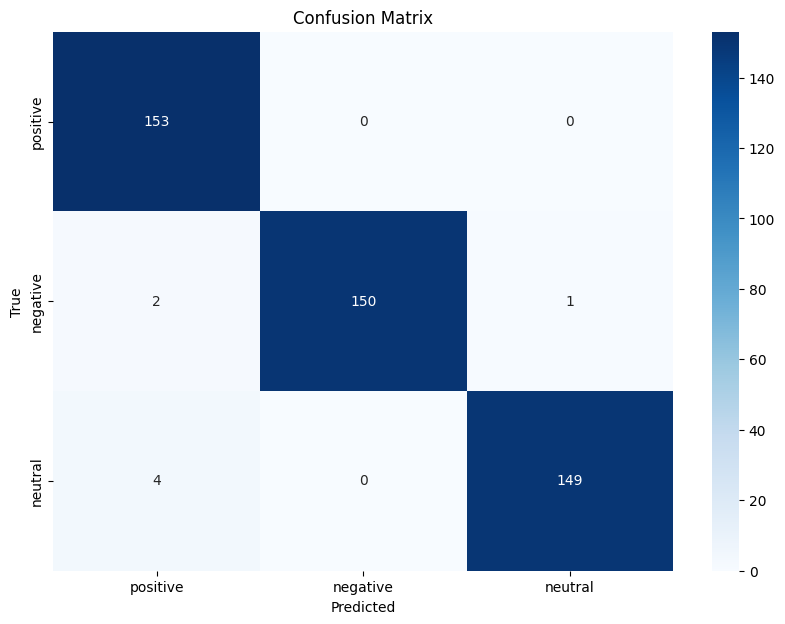

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
labels = ["positive", "negative", "neutral"]
cm = confusion_matrix(original_labels, predicted_labels, labels=labels)

# Print classification report
print(classification_report(original_labels, predicted_labels, target_names=labels))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Validation against handpicked news
10 recent news were selected from the web and feed into the fine-tuned model to predict their sentiment. Then, the author used his human intelligence to classify the sentiment of the same set of news.

In [34]:
# Define the news headlines
news_headlines = [
    "Tesla Delays Robotaxi Event in Blow to Musk’s Autonomy Drive",
    "Delta’s Sagging Profit Signals trouble for airlines this summer",
    "Global EV sales up 13% in June, down 7% in Europe",
    "Referendum set for South Dakota voters on controversial carbon dioxide pipeline law",
    "OpenAI Scale ranks progress toward ‘Human-Level’ Problem solving",
    "Costco stock has a 12% upside after raising its annual membership fees for the first time since 2017, according to Bank of America.",
    "Oil rose for a third day as optimism in wider financial markets, spurred by indications that US interest-rate cuts are on the way, helped to propel futures higher.",
    "US appeals court says some NCAA athletes may qualify as employees under federal wage-and-hour laws",
    "Extreme heat kills more people in the US than hurricanes, floods, and tornadoes combined.",
    "US would keep more hydropower under agreement with Canada under treaty governing Columbia River"
]

# Define the system message
system_message = "You are a helpful assistant to categorize news title as 'positive', 'negative', or 'neutral' based on its impact on stock prices from the viewpoint of a retail investor."

# Function to create prompt for the fine-tuned model
def create_prompt(title):
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": f"Title: {title}\nCategorize the news title as 'positive', 'negative', or 'neutral' based on its impact on stock prices from the viewpoint of a retail investor."}
    ]

# Function to make predictions using the fine-tuned GPT model
def predict_sentiment(title):
    prompt = create_prompt(title)
    response = client.chat.completions.create(
        model="ft:gpt-3.5-turbo-0125:personal::9jzE106Q",  # Replace with your fine-tuned model name
        messages=prompt
    )
    response_text = response.choices[0].message.content.strip().lower()
    # Ensure only the label is returned
    if "positive" in response_text:
        return "positive"
    elif "negative" in response_text:
        return "negative"
    elif "neutral" in response_text:
        return "neutral"
    else:
        return "unknown"  # Handle unexpected cases

# Categorize each news headline
predicted_labels = {title: predict_sentiment(title) for title in news_headlines}

# Print the results
for title, label in predicted_labels.items():
    print(f"Title: {title}\nPredicted Label: {label}\n")



Title: Tesla Delays Robotaxi Event in Blow to Musk’s Autonomy Drive
Predicted Label: negative

Title: Delta’s Sagging Profit Signals trouble for airlines this summer
Predicted Label: negative

Title: Global EV sales up 13% in June, down 7% in Europe
Predicted Label: positive

Title: Referendum set for South Dakota voters on controversial carbon dioxide pipeline law
Predicted Label: neutral

Title: OpenAI Scale ranks progress toward ‘Human-Level’ Problem solving
Predicted Label: positive

Title: Costco stock has a 12% upside after raising its annual membership fees for the first time since 2017, according to Bank of America.
Predicted Label: positive

Title: Oil rose for a third day as optimism in wider financial markets, spurred by indications that US interest-rate cuts are on the way, helped to propel futures higher.
Predicted Label: positive

Title: US appeals court says some NCAA athletes may qualify as employees under federal wage-and-hour laws
Predicted Label: positive

Title: Ext

Using the chat completions API along with the fine-tuned model, it seems to predict the news sentiments quite accurately.

As a human, I agree with all the prediction made by the fine-tuned model on the 10 news above. Though the news of heat waves taking people's lives may not be financial news, I'd argue that it be classified as neutral. However, any extreme weather conditions have historically had impacts on the stock prices.

Therefore, it can be concluded that the fine-tuned model is capable of performing at human-level intelligence in some cases.